Structure of the paper will be as follows...

R2 - IS and OOS, boostrap errors.

New Loss function v random - IS and OOS, boostrap errors.

### 0.0 Inputs...

In [1]:
from __future__ import division, print_function

import joblib
import numpy as np
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock
from scipy import stats

from multiprocessing import Pool
from copy import deepcopy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model as LM

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR

# Baseline Deep learning model.
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Bigger deep learning model with intermediate layer...
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5, verbose=0)))

# Model dictionaries 
model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}, },
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 
                                                              'n_jobs':4, 'max_depth':10}, },
              'svr'   : {'m' : SVR, 'kw' : {}, },
              
              'dl_l'   : {'m' : Pipeline, 
                          'kw' : {'steps': [('standardize', StandardScaler()),
                                            ('mlp', KerasRegressor(build_fn=larger_model, 
                                                                   epochs=100, batch_size=5, 
                                                                   verbose=0))
                                                           ]},
                         },
             }

# Datasets
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
rerun = False

In [3]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    return preds, resps, smiles

## 1.0 Different models. R^2 loss

### 1.1  Insample

This is just a check of how R^2 does insample on the various models (currently just ridge and RF) that we examine. Obviously we expect RF to massively outperform Ridge given its ability to overfit...

In [4]:
def regress(response, pred_list, one=False, do_print=True):

    regr = LM.LinearRegression(fit_intercept=one)
    regr.fit(np.asarray(pred_list).swapaxes(0, 1), response)
    
    presp = regr.predict(np.asarray(pred_list).swapaxes(0, 1))
    r2 = r2_score(response, presp)
    if do_print:
        if one:
            rs = ('%6.4f '* (len(pred_list) + 1)) % (tuple(regr.coef_) + (regr.intercept_,))
        else:
            rs = ('%6.4f '* (len(pred_list)) % tuple(regr.coef_))
        print ('Coeffs:       ' + rs)
        print ('R-squared: {:9.4f}'.format(r2))
    else:
        return regr.coef_, r2

In [8]:
insample_rs_hdr = {}

for method in model_dict.keys():
    insample_rs_hdr[method] = []
    pass

for tgt in targets:
    print ('Doing', tgt)
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        mdl = model_dict[m]['m'](**model_dict[m]['kw'])
        mdl.fit(preds, resps)
        fc = mdl.predict(preds)
        
        beta, r2 = regress(resps, [fc,], do_print=False)
        insample_rs_hdr[m].append(np.sign(beta[0])*r2)
        pass
    pass

Doing A2a


/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Doing ABL1
Doing Acetylcholinesterase
Doing Androgen
Doing Aurora-A
Doing B-raf
Doing Cannabinoid
Doing Carbonic
Doing Caspase
Doing Coagulation
Doing COX-1
Doing COX-2
Doing Dihydrofolate
Doing Dopamine
Doing Ephrin
Doing erbB1
Doing Estrogen
Doing Glucocorticoid
Doing Glycogen
Doing HERG
Doing JAK2
Doing LCK
Doing Monoamine
Doing opioid
Doing Vanilloid


In [9]:
figsize(20, 10)

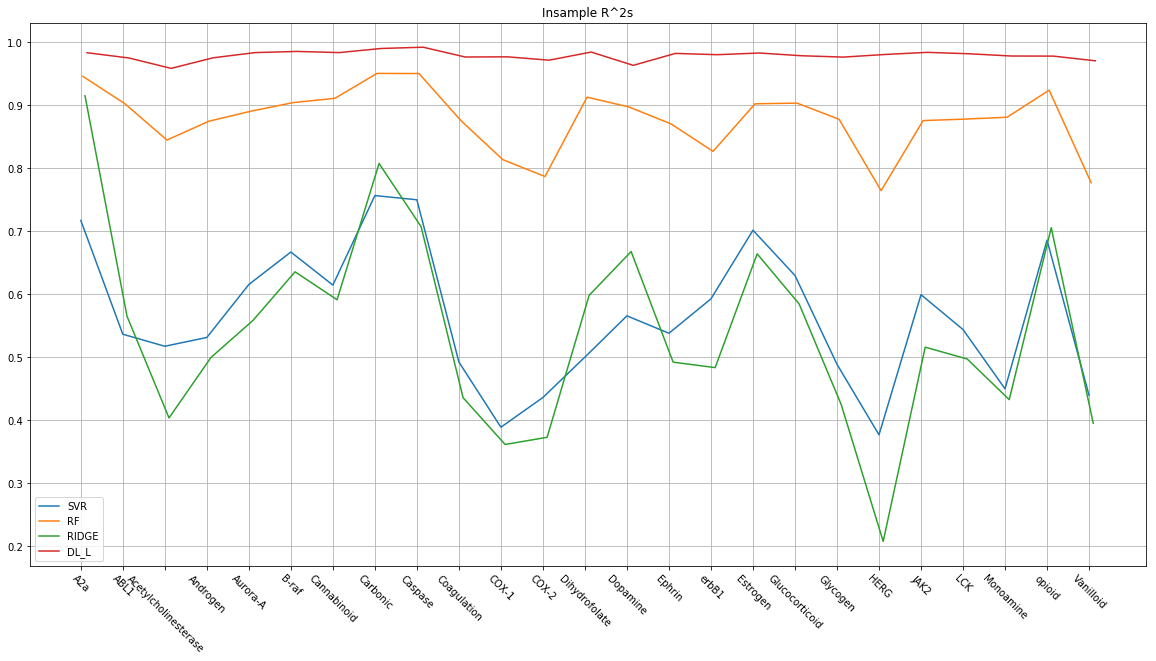

In [10]:
for (i, method) in enumerate(model_dict.keys()):
    plot(np.arange(25) + 0.05*i, insample_rs_hdr[method],  label=method.upper())
grid(True)
title('Insample R^2s')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

### 1.2 Out of sample (with bootstrap error bars)

In [5]:
def bs_run(kwargs):
    my_is = kwargs.get('is')
    my_oos = kwargs.get('oos')
    method = kwargs.get('method')
    preds = kwargs.get('preds')
    resps = kwargs.get('resps')
    
    mdl = model_dict[method]['m'](**model_dict[method]['kw'])
    mdl.fit(preds[my_is], resps[my_is])
        
    beta, r2 = regress(resps[my_oos], [mdl.predict(preds[my_oos]),], do_print=False, one=False)
    if beta < 0:
        r2 *= -1
        pass
    return r2

def full_bootstrap(preds, resps, method, num_runs=40, do_print=True, frac_fit=1.0):

    r_2s = []
    betas = []
    sorted_indices = np.argsort(resps)

    N = len(resps)
    M = int(N * frac_fit)
    
    idx_tuples = []
    for i in range(num_runs):
        idcs_rand = np.random.choice(M, M)
        idcs = sorted_indices[idcs_rand]
        oos = np.delete(np.arange(N), idcs)
        idx_tuples.append({'is' : idcs, 'oos' : oos, 'preds' : preds, 'resps' : resps, 'method' : method})
        pass

    p = Pool(5)
    p.map(bs_run, idx_tuples)
    r_2s = np.asarray(p.map(bs_run, idx_tuples))
    p.close()
    p.join()
    
    if do_print:
        print ('R2 (signed):  %9.3f [%8.3f %8.3f] at 5pct conf' % 
               (np.median(r_2s), np.percentile(r_2s, 5), np.percentile(r_2s, 95)))
        
    else:
        r2 = np.median(r_2s)
        r2_l = np.percentile(r_2s, 5)
        r2_u = np.percentile(r_2s, 95)
        return {'r2' : r2, 'r2_l' : r2_l, 'r2_u' : r2_u}

In [6]:
preds, resps, _ = get_data('HERG')
full_bootstrap(preds, resps, 'ridge')

R2 (signed):      0.152 [   0.114    0.172] at 5pct conf


In [7]:
if rerun:
    oos_rs_hdr = {m : {x : [] for x in ks} for m in model_dict.keys()}

    for tgt in targets:
        print ('Doing', tgt)
        preds, resps, _ = get_data(tgt)
        preds = preds + 0.
    
        for m in model_dict.keys():
            res = full_bootstrap(preds, resps, m, do_print=False)
            for k in ks:
                oos_rs_hdr[m][k].append(res[k])
                pass
            pass
        pass
    joblib.dump(oos_rs_hdr, 'models/oos_rs_values')
    pass
else:
    oos_rs_hdr = joblib.load('models/oos_rs_values')
    pass

In [8]:
figsize(20,10)

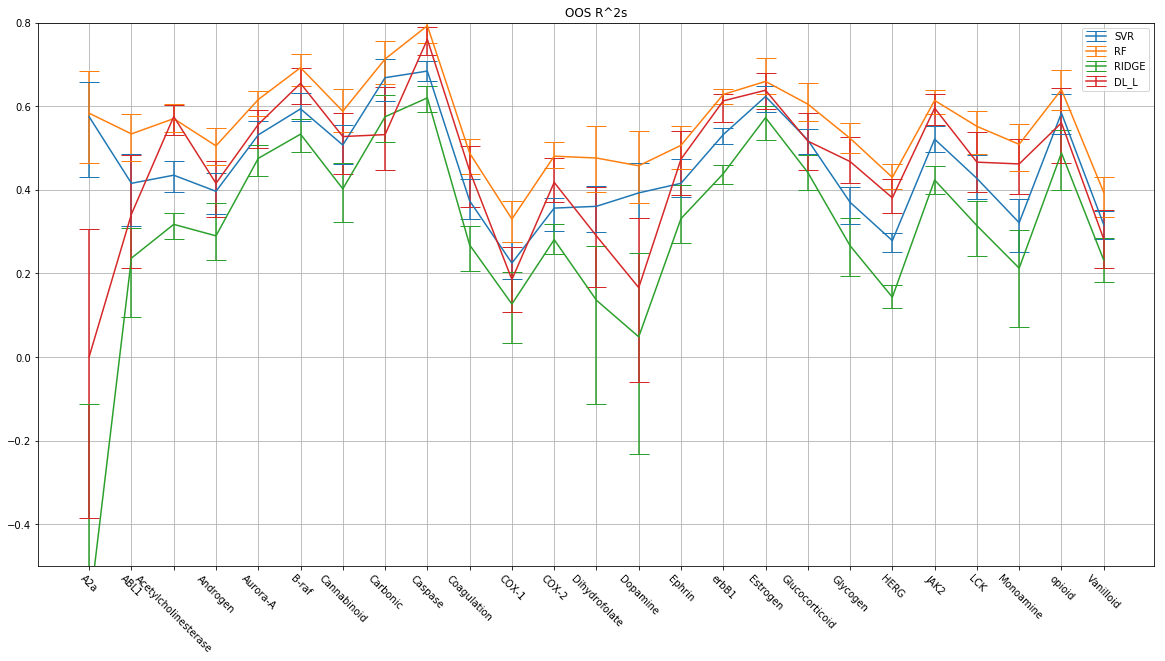

In [9]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_rs_hdr[method]['r2'])
    rfe = np.vstack((rf - np.asarray(oos_rs_hdr[method]['r2_l']),
                 np.asarray(oos_rs_hdr[method]['r2_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

grid(True)
title('OOS R^2s')
plt.xticks(np.arange(25), targets, rotation=-45)
plt.ylim((-0.5, .8))
legend(loc='best')

In [10]:
for method in model_dict.keys():
    print (method, np.mean(oos_rs_hdr[method]['r2']))

svr 0.456748502425
rf 0.555260934831
ridge 0.302496786054
dl_l 0.45278966133


In [11]:
for method in model_dict.keys():
    err = np.array(oos_rs_hdr[method]['r2_u']) - np.array(oos_rs_hdr[method]['r2_l'])
    print (method, np.average(oos_rs_hdr[method]['r2'], weights=1./(err*err)))

svr 0.478319363197
rf 0.571902653331
ridge 0.391339887027
dl_l 0.545935844697


### Decreasing max activity in fit...

#### Max activity at 80%....

In [12]:
if rerun:
    oos_rs_hdr_08 = {m : {x : [] for x in ks} for m in model_dict.keys()}

    for tgt in targets:
        preds, resps, _ = get_data(tgt)
        for m in model_dict.keys():
            res = full_bootstrap(preds, resps, m, do_print=False, frac_fit=0.8)
            for k in ks:
                oos_rs_hdr_08[m][k].append(res[k])
                pass
            pass
        pass
    joblib.dump(oos_rs_hdr_08, 'models/oos_rs_values_08')
else:
    oos_rs_hdr_08 = joblib.load('models/oos_rs_values_08')

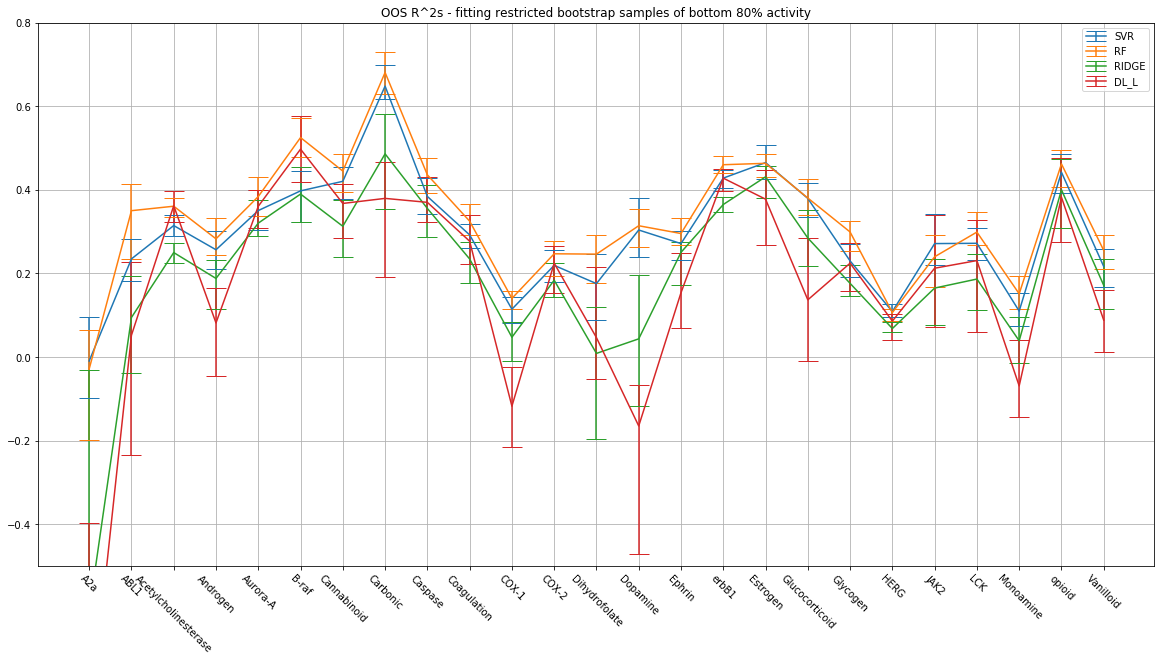

In [13]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_rs_hdr_08[method]['r2'])
    rfe = np.vstack((rf - np.asarray(oos_rs_hdr_08[method]['r2_l']),
                 np.asarray(oos_rs_hdr_08[method]['r2_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

grid(True)
title('OOS R^2s - fitting restricted bootstrap samples of bottom 80% activity')
plt.xticks(np.arange(25), targets, rotation=-45)
plt.ylim((-0.5, .8))
legend(loc='best')

#### Max activity at 60%...

In [14]:
# Has run already! 
if rerun:
    oos_rs_hdr_06 = {m : {x : [] for x in ks} for m in model_dict.keys()}

    for tgt in targets:
        preds, resps, _ = get_data(tgt)
        for m in model_dict.keys():
            res = full_bootstrap(preds, resps, m, do_print=False, frac_fit=0.6)
            for k in ks:
                oos_rs_hdr_06[m][k].append(res[k])
                pass
            pass
        pass
    joblib.dump(oos_rs_hdr_06, 'models/oos_rs_values_06')
else:
    oos_rs_hdr_06 = joblib.load('models/oos_rs_values_06')
    pass

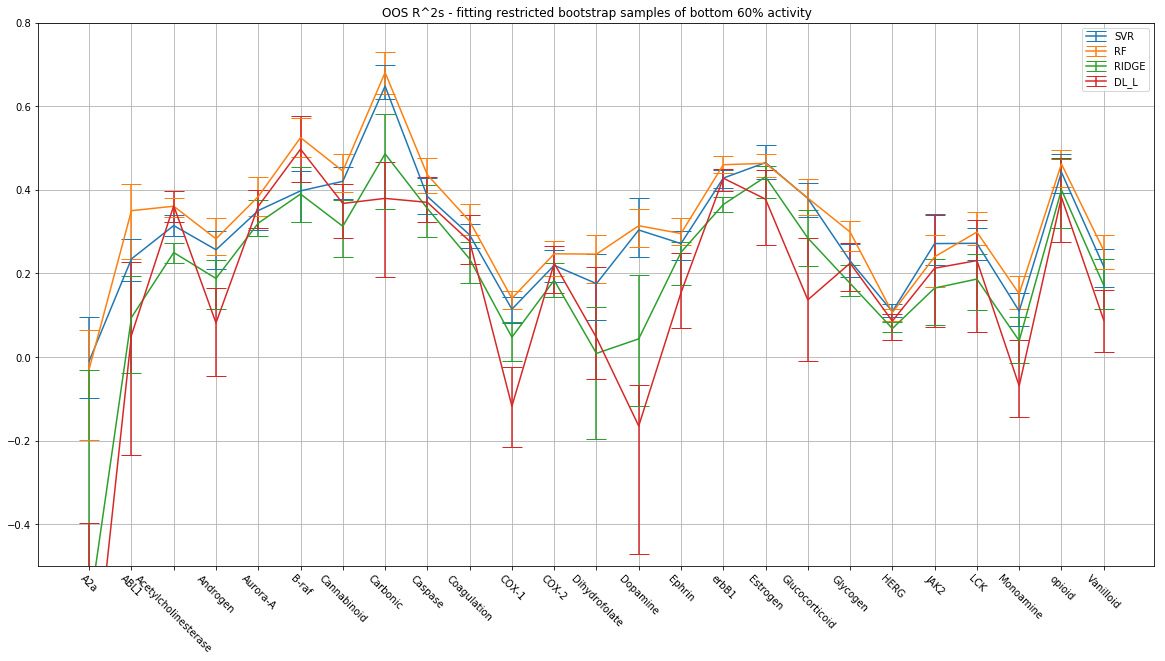

In [15]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_rs_hdr_08[method]['r2'])
    rfe = np.vstack((rf - np.asarray(oos_rs_hdr_08[method]['r2_l']),
                 np.asarray(oos_rs_hdr_08[method]['r2_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

grid(True)
title('OOS R^2s - fitting restricted bootstrap samples of bottom 60% activity')
plt.xticks(np.arange(25), targets, rotation=-45)
plt.ylim((-0.5, .8))
legend(loc='best')

## New loss function

In [ ]:
frac_find = 0.9

insample_loss_hdr = {}

for method in model_dict.keys():
    insample_loss_hdr[method] = []
    pass

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    N = len(resps)
    tgt_val = np.percentile(resps, frac_find*100)
    
    for m in model_dict.keys():
        mdl = model_dict[m]['m'](**model_dict[m]['kw'])
        mdl.fit(preds, resps)
        predictions = mdl.predict(preds)
        ranked = np.argsort(-predictions)
        found = resps[ranked] >= tgt_val
        loss = np.mean(np.arange(N)[found])*2/N
        
        insample_loss_hdr[m].append(loss)
        pass
    pass

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
for (i, method) in enumerate(model_dict.keys()):
    plot(np.arange(25) + 0.05*i, insample_loss_hdr[method],  label=method.upper())

grid(True)
title('Insample (New) Loss (1 = Random)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [ ]:
def nbs_run(kwargs):
    my_is = kwargs.get('is')
    my_oos = kwargs.get('oos')
    method = kwargs.get('method')
    preds = kwargs.get('preds')
    resps = kwargs.get('resps')
    
    mdl = model_dict[method]['m'](**model_dict[method]['kw'])
    mdl.fit(preds[my_is], resps[my_is])
        
    predictions = mdl.predict(preds[my_oos])
    ranked = my_oos[np.argsort(-predictions)]
    found = resps[ranked] >= tgt_val
            
    # LOSS (so small values are good) is the mean rank of the good molecules in the order
    # you rank them vs random (in which case the mean value would be half the length of the array)
    loss = np.mean(np.arange(len(my_oos))[found])*2/len(my_oos)
    return loss

    
def full_bs_new_loss(preds, resps, method, num_runs=100, do_print=True, frac_fit=1.0, frac_find=0.9):

    losses = []
    sorted_indices = np.argsort(resps)

    N = len(resps)
    M = int(N * frac_fit)
    n = int(N*frac_find)
    tgt_val = resps[sorted_indices[n]]
    
    idx_tuples = []
    for i in range(num_runs):
        idcs_rand = np.random.choice(M, M)
        idcs = sorted_indices[idcs_rand]
        oos = np.delete(np.arange(N), idcs)
        idx_tuples.append({'is' : idcs, 'oos' : oos, 'preds' : preds, 'resps' : resps, 'method' : method})
        pass

    p = Pool(5)
    losses = np.asarray(p.map(nbs_run, idx_tuples))
    p.close()
    p.join()
        
    if do_print:
        print ('Loss:  %9.3f [%8.3f %8.3f] at 5pct conf' % 
               (np.median(losses), np.percentile(losses, 5), np.percentile(losses, 95)))      
    else:
        loss = np.median(losses)
        loss_l = np.percentile(losses, 5)
        loss_u = np.percentile(losses, 95)
        return {'loss' : loss, 'loss_l' : loss_l, 'loss_u' : loss_u}

In [ ]:
lks = ['loss', 'loss_l', 'loss_u']

oos_loss_hdr = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    print('Doing', tgt)
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False)
        for k in lks:
            oos_loss_hdr[m][k].append(res[k])
            pass
        pass
    pass


joblib.dump(oos_loss_hdr, 'models/oos_loss_values')

In [ ]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_loss_hdr[method]['loss'])
    rfe = np.vstack((rf - np.asarray(oos_loss_hdr[method]['loss_l']),
                 np.asarray(oos_loss_hdr[method]['loss_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

grid(True)
title('OOS Losses')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [ ]:
oos_loss_hdr_09 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    print ('Doing ', tgt)
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.9)
        for k in lks:
            oos_loss_hdr_09[m][k].append(res[k])
            pass
        pass
    pass

joblib.dump(oos_loss_hdr_09, 'models/oos_loss_values_09')

In [ ]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_loss_hdr_09[method]['loss'])
    rfe = np.vstack((rf - np.asarray(oos_loss_hdr_09[method]['loss_l']),
                 np.asarray(oos_loss_hdr_09[method]['loss_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

grid(True)
title('OOS Losses (max training at 90% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [ ]:
oos_loss_hdr_08 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.8)
        for k in lks:
            oos_loss_hdr_08[m][k].append(res[k])
            pass
        pass
    pass

joblib.dump(oos_loss_hdr_08, 'models/oos_loss_values_08')

In [ ]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_loss_hdr_08[method]['loss'])
    rfe = np.vstack((rf - np.asarray(oos_loss_hdr_08[method]['loss_l']),
                 np.asarray(oos_loss_hdr_08[method]['loss_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('OOS Losses (max training at 80% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [ ]:
oos_loss_hdr_06 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    print ('Doing', tgt)
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.6)
        for k in lks:
            oos_loss_hdr_06[m][k].append(res[k])
            pass
        pass
    pass

joblib.dump(oos_loss_hdr_06, 'models/oos_loss_values_06')

In [ ]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_loss_hdr_06[method]['loss'])
    rfe = np.vstack((rf - np.asarray(oos_loss_hdr_06[method]['loss_l']),
                 np.asarray(oos_loss_hdr_06[method]['loss_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('OOS Losses (max training at 60% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

In [ ]:
oos_loss_hdr_04 = {m : {x : [] for x in lks} for m in model_dict.keys()}

for tgt in targets:
    preds, resps, _ = get_data(tgt)
    for m in model_dict.keys():
        res = full_bs_new_loss(preds, resps, m, do_print=False, frac_fit=0.4)
        for k in lks:
            oos_loss_hdr_04[m][k].append(res[k])
            pass
        pass
    pass

joblib.dump(oos_loss_hdr_04, 'models/oos_loss_values_04')

In [ ]:
for (i, method) in enumerate(model_dict.keys()):
    rf = np.asarray(oos_loss_hdr_04[method]['loss'])
    rfe = np.vstack((rf - np.asarray(oos_loss_hdr_04[method]['loss_l']),
                 np.asarray(oos_loss_hdr_04[method]['loss_u'])-rf))
    errorbar(np.arange(25), rf, capsize=10, yerr=rfe, label=method.upper())
    pass

plot(np.arange(25), np.ones(25), label='Random')
grid(True)
title('OOS Losses (max training at 40% percentile)')
plt.xticks(np.arange(25), targets, rotation=-45)
legend(loc='best')

Let's compare the log likelihoods of the two models (vs random) assuming independence of datasets (also - since loss function is not distributed perfectly normally, when better than random we will use the upper error estimate, when worse than random we will use the lower error estimate, and when the random line (1.0) lies within the error estimates we will use the average...

In [ ]:
def ll_estimate(loss_hdr, k='loos', ctr=1., sc=1.):
    
    for method in model_dict.keys():
        vals = np.asarray(loss_hdr[method][k])
        upper = np.asarray(loss_hdr[method][k + '_u'])
        lower = np.asarray(loss_hdr[method][k + '_l'])
        
        sigma = vals * np.nan
        # recall - these are 5% conf intervals, i.e. 2-sigma error bars
        sigma[upper < ctr] = ((upper - vals) / 2.)[upper < ctr]  
        sigma[lower > ctr] = ((vals - lower) / 2.)[lower > ctr]
        sigma[np.isnan(sigma)] = ((upper - lower) / 4.)[np.isnan(sigma)]
        assert((sigma > 0).all())
        
        dists = (vals - 1) / sigma
        ll = sc * np.sum(np.sign(dists) * dists*dists) / 2.
        print('%10s  %9.3f' % (method, ll))
    
    return

In [ ]:
ll_estimate(oos_loss_hdr)

In [ ]:
ll_estimate(oos_loss_hdr_09)

In [ ]:
ll_estimate(oos_loss_hdr_08)

In [ ]:
ll_estimate(oos_loss_hdr_06)

In [ ]:
ll_estimate(oos_loss_hdr_04)

Awesome - we have the answer.  Ridge starts to beat random forest once you're extrapolating from below 70% to try and get the top 90%...